In [32]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch import nn
from torch.nn import functional as F

import src.dag_utils as dagu
import src.utils as utils
from src.arch import DAGConv, FB_DAGConv, SF_DAGConv
from src.models import SrcIdModel
from src.baselines_archs import MyGCNN, GAT, MLP, GraphSAGE, GIN

# Ser random seed
SEED = 10
PATH = 'results/src_id/'
SAVE = True
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

### Default parameters and auxiliary functions

In [33]:
M = 2000

data_p = {
    'n_tries': 25,

    ## Graph parameters
    'p': 0.2,                    # Edge prob in Erdos-Renyi DAG
    'N': 100,                    # Number of nodes

    ## Signal parameters
    'M': M,                   # Number of observed signals
    'M_train': int(0.7 * M),  # Samples selected for training
    'M_val': int(0.2 * M),    # Samples selected for validation
    'M_test': int(0.1 * M),   # Samples selected for test
    'src_t': 'random',          # 'random' or 'constant'
    'max_src_node': 10,           # Maximum index of nodes allowed to be sources
    'n_sources': 1,              # Maximum Number of source nodes
    'n_p': .05,                 # Normalized noise power
    'max_GSO': 100,              # Maximum index of GSOs involved in the diffusion
    'min_GSO': 50,               # Minimum index of GSOs involved in the diffusion
    'n_GSOs': 25                 # Number of GSOs
}

# Model parameters
default_arch_p = {
    'in_dim': 1,        # Input dimension
    'hid_dim': 16,     # Hidden dimension
    'out_dim': 1,       # Output dimension
    'L': 2,  # 3 also works well          # Number of layers
    'l_act': None,
}

default_mod_p = {
    'bs': 25,           # Size of the batch
    'lr': 5e-3,         # Learning rate
    'epochs': 50,       # Number of training epochs 
    'pat': 15,          # Number of non-decreasing epoch to stop training
    'wd': 1e-4,         # Weight decay
}

##########   AUXILIARY FUNCTIONS   ##########   
def get_signals(d_p, GSOs):
    range_GSO = np.arange(d_p['min_GSO'], d_p['max_GSO'])
    gsos_idx = np.random.choice(range_GSO, size=d_p['n_GSOs'], replace=False)
    sel_GSOs = GSOs[gsos_idx]
    signals_t, sources_t = dagu.create_diff_data(d_p['M'], sel_GSOs, d_p['max_src_node'], d_p['n_p'],
                                                d_p['n_sources'], src_t=d_p['src_t'], torch_tensor=True,
                                                mask_sources=True)
    labels_t = torch.argmax(torch.abs(sources_t), axis=1)

    signals = {'train': signals_t[:d_p['M_train']], 'val': signals_t[d_p['M_train']:-d_p['M_test']],
                 'test': signals_t[-d_p['M_test']:]}
    labels = {'train': labels_t[:d_p['M_train']], 'val': labels_t[d_p['M_train']:-d_p['M_test']],
              'test': labels_t[-d_p['M_test']:]}
    return signals, labels, sel_GSOs


def run_exp(d_p, d_arc_p, d_mod_p, exps):
    acc = np.zeros((d_p['n_tries'], len(exps)))
    times = np.zeros((d_p['n_tries'], len(exps)))

    t_begin = time.time()
    for i in range(d_p['n_tries']):
        # TODO: modify graph generating proces to ensure some graphs are only sources!
        Adj, W, GSOs = utils.get_graph_data(d_p)
        signals, labels, sel_GSOs = get_signals(d_p, GSOs)

        for j, exp in enumerate(exps):
            arc_p = {**d_arc_p, **exp['arc_p']} if 'arc_p' in exp else d_arc_p
            mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p

            GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
            K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0 
            arch = utils.instantiate_arch(arc_p, K)
            model = SrcIdModel(arch, device=device)

            t_i = time.time()
            model.fit(signals, labels, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                      patience=mod_p['pat'])
            t_e = time.time() - t_i

            acc[i,j] = model.test(signals['test'], labels['test'], GSO)
            times[i,j] = t_e

            print(f'-{i}. {exp["leg"]}: acc: {acc[i,j]:.3f} - time: {times[i,j]:.1f}')
    
    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times


def run_exps(exps, d_arc_p, d_mod_p, d_dat_p, GSOs, W, Adj, exp_desc='default'):
    acc_exps = np.zeros(len(exps))
    times_exps = np.zeros(len(exps))
    
    signals, labels, sel_GSOs = get_signals(d_dat_p, GSOs)
    
    for k, exp in enumerate(exps):
        arc_p = {**d_arc_p, **exp['arc_p']}
        mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p

        GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
        K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0 
        arch = utils.instantiate_arch(arc_p, K)
        model = SrcIdModel(arch, device=device)
        
        t_i = time.time()
        model.fit(signals, labels, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                  patience=mod_p['pat'])
        t_e = time.time() - t_i
        
        acc_exps[k] = model.test(signals['test'], labels['test'], GSO)
        times_exps[k] = t_e

        print(f'\t-{exp_desc}. {exp["leg"]}: acc: {acc_exps[k]:.3f} - time: {times_exps[k]:.1f}')

    return acc_exps, times_exps

## Initial Test - As classification problem

In [34]:
Exps = [
    # DAG based architectures
    # {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'DAGCNN'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'DAGCNN-Prior'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'DAGCNN-Rnd-30'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'FB-DAGCNN'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'leg': 'FB-DAGCNN-Prior'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'FB-DAGCNN-Rnd-30'},

    # DAG based architectures with Transpose GSOs
    # {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs', 'transp': True}, 'leg': 'DAGCNN-T'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'sel_GSOs', 'transp': True}, 'leg': 'DAGCNN-Prior-T'},
    {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DAGCNN-Rnd-30-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True}, 'leg': 'FB-DAGCNN-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs', 'transp': True}, 'leg': 'FB-DAGCNN-Prior-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'transp': True, 'n_gsos': 5}, 'leg': 'FB-DAGCNN-Rnd-5-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'transp': True, 'n_gsos': 30}, 'leg': 'FB-DAGCNN-Rnd-30-T'},

    # Baselines
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W'}, 'leg': 'GNN-W'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A-T'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W', 'transp': True}, 'leg': 'GNN-W-T'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'mod_p': {}, 'leg': 'MLP'},

    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'n_heads': 2, 'hid_dim': 16,'gat_params': {'attn_drop': 0}},
      'leg': 'GAT-A'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'transp': True, 'n_heads': 2, 'hid_dim': 16,'gat_params': {'attn_drop': 0}},
      'leg': 'GAT-A-T'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean', 'transp': False,},
     'leg': 'GraphSAGE-A'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'mean', 'transp': True,},
     'leg': 'GraphSAGE-A-T'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum', 'transp': False}, 'leg': 'GIN-A'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'hid_dim': 16, 'agg': 'sum', 'transp': True}, 'leg': 'GIN-A-T'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'mod_p': {}, 'leg': 'MLP'},    
]

acc, times = run_exp(data_p, default_arch_p, default_mod_p, Exps)

-0. DAGCNN-Prior: acc: 0.125 - time: 4.2
-0. DAGCNN-Rnd-30: acc: 0.125 - time: 4.7
-0. FB-DAGCNN: acc: 0.075 - time: 3.4
-0. FB-DAGCNN-Prior: acc: 0.120 - time: 3.5
-0. FB-DAGCNN-Rnd-30: acc: 0.105 - time: 2.9
-0. DAGCNN-Prior-T: acc: 0.965 - time: 4.8
-0. DAGCNN-Rnd-30-T: acc: 1.000 - time: 4.8
-0. FB-DAGCNN-T: acc: 1.000 - time: 3.5
-0. FB-DAGCNN-Prior-T: acc: 1.000 - time: 3.2
-0. FB-DAGCNN-Rnd-5-T: acc: 0.830 - time: 3.6
-0. FB-DAGCNN-Rnd-30-T: acc: 1.000 - time: 3.3
-0. GNN-A: acc: 0.125 - time: 3.3
-0. GNN-W: acc: 0.080 - time: 2.4
-0. GNN-A-T: acc: 0.080 - time: 2.0
-0. GNN-W-T: acc: 0.080 - time: 1.9
-0. MLP: acc: 0.125 - time: 2.7
-0. GAT-A: acc: 0.000 - time: 4.6
-0. GAT-A-T: acc: 0.000 - time: 4.2
-0. GraphSAGE-A: acc: 0.920 - time: 5.4
-0. GraphSAGE-A-T: acc: 0.920 - time: 5.3
-0. GIN-A: acc: 0.405 - time: 4.8
-0. GIN-A-T: acc: 0.290 - time: 4.7
-0. MLP: acc: 0.110 - time: 2.0
-1. DAGCNN-Prior: acc: 0.130 - time: 4.3
-1. DAGCNN-Rnd-30: acc: 0.065 - time: 5.0
-1. FB-DAGCNN: 

In [35]:
# No noise
if SAVE:
    file_name = PATH + f'init_exp'
    np.savez(file_name, acc=acc, times=times)
    print('SAVED FILE:', file_name)  

leg = [exp['leg'] for exp in Exps]
utils.display_data(leg, acc, None, times, metric_label='Acc')

SAVED FILE: results/src_id/init_exp


,Exp,Mean Acc,Median Acc,Mean Std,time
0,DAGCNN-Prior,0.0990,0.095,None,4.643290
1,DAGCNN-Rnd-30,0.0922,0.095,None,4.550976
2,FB-DAGCNN,0.0928,0.090,None,3.294048
3,FB-DAGCNN-Prior,0.1028,0.100,None,3.467126
4,FB-DAGCNN-Rnd-30,0.0956,0.095,None,3.417807
5,DAGCNN-Prior-T,0.6778,0.655,None,4.745799
6,DAGCNN-Rnd-30-T,0.9422,0.995,None,4.713676
7,FB-DAGCNN-T,0.9844,1.000,None,3.416344
8,FB-DAGCNN-Prior-T,0.9818,0.995,None,3.452787
9,FB-DAGCNN-Rnd-5-T,0.5818,0.555,None,3.441340


## Influence of the number of source nodes

In [5]:
def influence_sources_exp(d_dat_p, d_arc_p, d_mod_p, Max_sources, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(Max_sources), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Max_sources), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        Adj, W, GSOs = utils.get_graph_data(d_dat_p)

        for j, max_srcs in enumerate(Max_sources):
            data_params_aux = dict(d_dat_p)
            data_params_aux['max_src_node'] = max_srcs
            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(max_srcs))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [6]:
Max_sources = np.arange(10, 91, 10)

Exps = [

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'FB-DAGCNN-T', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs', 'transp': True}, 'leg': 'FB-DAGCNN-Prior-T',
     'fmt': 'P-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'FB-DAGCNN-Rnd-15-T',
     'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': False},'leg': 'FB-DAGCNN', 'fmt': 'o--'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A-T', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W', 'transp': True}, 'leg': 'GNN-W-T', 'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP', 'fmt': '>:'},
    ]

acc, times = influence_sources_exp(data_p, default_arch_p, default_mod_p, Max_sources, Exps)


Iteration: 0
	-10. FB-DAGCNN-T: acc: 1.000 - time: 4.0
	-10. FB-DAGCNN-Prior-T: acc: 1.000 - time: 4.0
	-10. FB-DAGCNN-Rnd-15-T: acc: 1.000 - time: 4.1
	-10. FB-DAGCNN: acc: 0.115 - time: 3.9
	-10. GNN-A-T: acc: 0.100 - time: 1.6
	-10. GNN-W-T: acc: 0.100 - time: 1.6
	-10. MLP: acc: 0.090 - time: 2.4
	-20. FB-DAGCNN-T: acc: 0.995 - time: 2.2
	-20. FB-DAGCNN-Prior-T: acc: 0.990 - time: 4.1
	-20. FB-DAGCNN-Rnd-15-T: acc: 0.995 - time: 4.1
	-20. FB-DAGCNN: acc: 0.020 - time: 3.8
	-20. GNN-A-T: acc: 0.040 - time: 1.5
	-20. GNN-W-T: acc: 0.040 - time: 1.5
	-20. MLP: acc: 0.025 - time: 2.5
	-30. FB-DAGCNN-T: acc: 1.000 - time: 3.9
	-30. FB-DAGCNN-Prior-T: acc: 1.000 - time: 4.0
	-30. FB-DAGCNN-Rnd-15-T: acc: 1.000 - time: 4.2
	-30. FB-DAGCNN: acc: 0.040 - time: 4.2
	-30. GNN-A-T: acc: 0.015 - time: 1.4
	-30. GNN-W-T: acc: 0.015 - time: 1.4
	-30. MLP: acc: 0.050 - time: 2.4
	-40. FB-DAGCNN-T: acc: 1.000 - time: 3.9
	-40. FB-DAGCNN-Prior-T: acc: 0.995 - time: 4.0
	-40. FB-DAGCNN-Rnd-15-T: acc:

/home/srey/Investigacion/dag_conv_nn/src/dag_utils.py:148: RuntimeWarning: invalid value encountered in divide
  Y = Y / signal_norm


	-90. FB-DAGCNN-T: acc: 0.005 - time: 1.0
	-90. FB-DAGCNN-Prior-T: acc: 0.035 - time: 1.1
	-90. FB-DAGCNN-Rnd-15-T: acc: 0.040 - time: 1.1
	-90. FB-DAGCNN: acc: 0.000 - time: 1.2
	-90. GNN-A-T: acc: 0.000 - time: 1.1
	-90. GNN-W-T: acc: 0.000 - time: 1.1
	-90. MLP: acc: 0.000 - time: 0.7
Iteration: 3
	-10. FB-DAGCNN-T: acc: 0.895 - time: 4.2
	-10. FB-DAGCNN-Prior-T: acc: 0.865 - time: 4.1
	-10. FB-DAGCNN-Rnd-15-T: acc: 0.955 - time: 4.0
	-10. FB-DAGCNN: acc: 0.100 - time: 4.1
	-10. GNN-A-T: acc: 0.095 - time: 1.6
	-10. GNN-W-T: acc: 0.095 - time: 1.5
	-10. MLP: acc: 0.110 - time: 2.4
	-20. FB-DAGCNN-T: acc: 0.780 - time: 4.1
	-20. FB-DAGCNN-Prior-T: acc: 0.670 - time: 4.0
	-20. FB-DAGCNN-Rnd-15-T: acc: 0.700 - time: 4.0
	-20. FB-DAGCNN: acc: 0.065 - time: 3.7
	-20. GNN-A-T: acc: 0.065 - time: 1.6
	-20. GNN-W-T: acc: 0.065 - time: 1.4
	-20. MLP: acc: 0.040 - time: 2.5
	-30. FB-DAGCNN-T: acc: 0.995 - time: 4.1
	-30. FB-DAGCNN-Prior-T: acc: 0.990 - time: 4.1
	-30. FB-DAGCNN-Rnd-15-T: acc:

SAVED FILE: results/src_id/src_nodes_inf-random


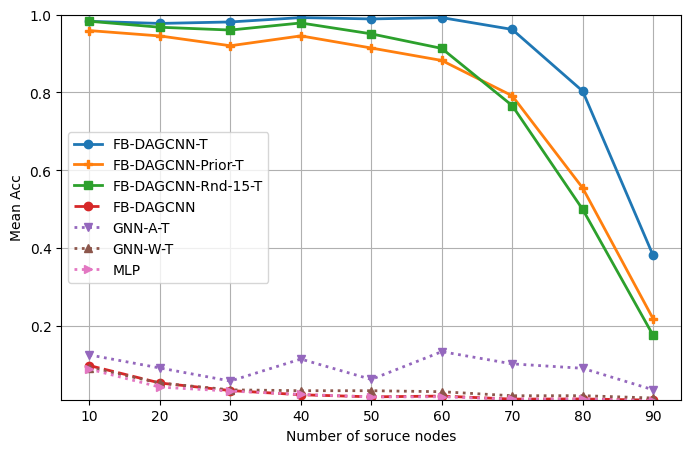

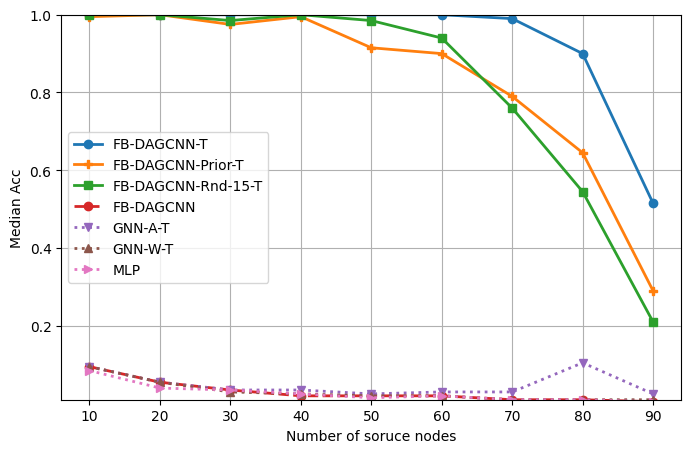

In [12]:
if SAVE:
    file_name = PATH + f'src_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=Max_sources)
    print('SAVED FILE:', file_name)

mean_acc = acc.mean(axis=0)
med_acc = np.median(acc, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_acc, Max_sources, Exps, 'Number of soruce nodes', logy=False,
                   ylabel='Mean Acc', n_cols=1)
utils.plot_results(med_acc, Max_sources, Exps, 'Number of soruce nodes', logy=False,
                   ylabel='Median Acc', n_cols=1)


In [10]:
file_name = PATH + 'src_nodes_inf-random.npz'
acc, times, Exps, Max_sources = utils.load_data(file_name, src_id=True)

## Influence of the graph

### Varying the density of the graph

In [9]:
def influence_graph_density(d_dat_p, d_arc_p, d_mod_p, P_values, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        for j, p in enumerate(P_values):
            data_params_aux = dict(d_dat_p)
            data_params_aux['p'] = p
            Adj, W, GSOs = utils.get_graph_data(data_params_aux)

            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(p))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [10]:
P_values = [.1, .2, .3, .4, .5, .6, .7, .8]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'FB-DAGCNN-T', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs', 'transp': True}, 'leg': 'FB-DAGCNN-Prior-T',
     'fmt': 'P-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'FB-DAGCNN-Rnd-30-T',
     'fmt': 's-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 15, 'transp': True}, 'leg': 'FB-DAGCNN-Rnd-15-T',
     'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': False},'leg': 'FB-DAGCNN', 'fmt': 'o--'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A-T', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W', 'transp': True}, 'leg': 'GNN-W-T', 'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP', 'fmt': '>:'},
    ]

acc, times = influence_graph_density(data_p, default_arch_p, default_mod_p, P_values, Exps)


Iteration: 0
	-0.1. FB-DAGCNN-T: acc: 1.000 - time: 3.9
	-0.1. FB-DAGCNN-Prior-T: acc: 1.000 - time: 3.8
	-0.1. FB-DAGCNN-Rnd-30-T: acc: 1.000 - time: 3.8
	-0.1. FB-DAGCNN-Rnd-15-T: acc: 1.000 - time: 3.7
	-0.1. FB-DAGCNN: acc: 0.080 - time: 4.1
	-0.1. GNN-A-T: acc: 0.110 - time: 1.5
	-0.1. GNN-W-T: acc: 0.095 - time: 1.5
	-0.1. MLP: acc: 0.100 - time: 2.5
	-0.2. FB-DAGCNN-T: acc: 0.870 - time: 3.6
	-0.2. FB-DAGCNN-Prior-T: acc: 0.870 - time: 4.1
	-0.2. FB-DAGCNN-Rnd-30-T: acc: 0.905 - time: 3.7
	-0.2. FB-DAGCNN-Rnd-15-T: acc: 0.860 - time: 4.1
	-0.2. FB-DAGCNN: acc: 0.120 - time: 4.2
	-0.2. GNN-A-T: acc: 0.115 - time: 3.1
	-0.2. GNN-W-T: acc: 0.115 - time: 3.8
	-0.2. MLP: acc: 0.105 - time: 2.5
	-0.3. FB-DAGCNN-T: acc: 1.000 - time: 3.9
	-0.3. FB-DAGCNN-Prior-T: acc: 1.000 - time: 4.1
	-0.3. FB-DAGCNN-Rnd-30-T: acc: 1.000 - time: 4.3
	-0.3. FB-DAGCNN-Rnd-15-T: acc: 1.000 - time: 3.9
	-0.3. FB-DAGCNN: acc: 0.100 - time: 4.1
	-0.3. GNN-A-T: acc: 0.100 - time: 1.6
	-0.3. GNN-W-T: acc: 0.

SAVED FILE: results/src_id/density_inf-random


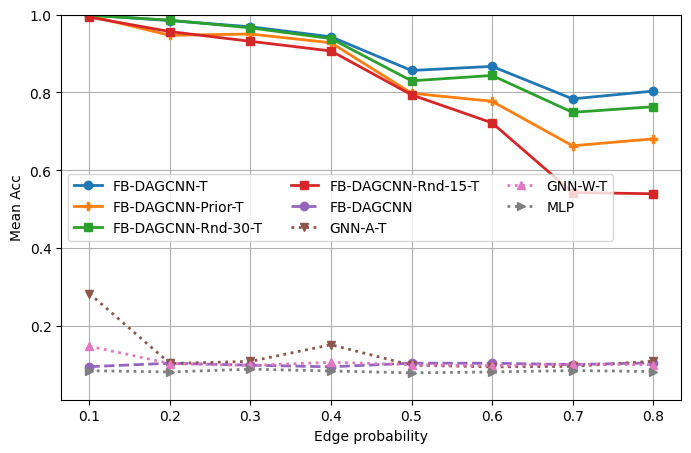

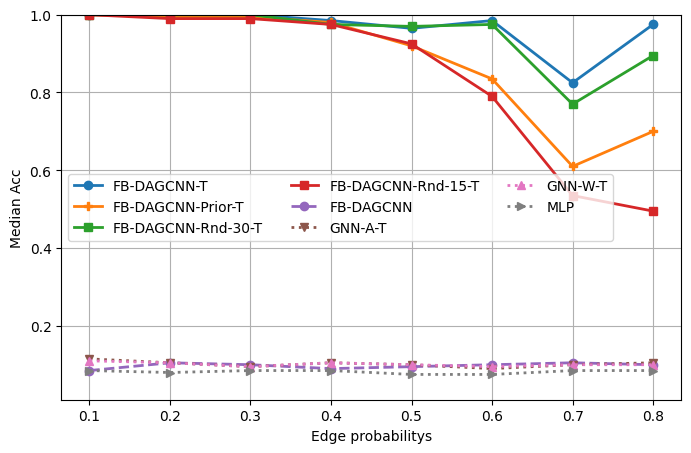

In [15]:
if SAVE:
    file_name = PATH + f'density_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=P_values)
    print('SAVED FILE:', file_name)

mean_acc = acc.mean(axis=0)
med_acc = np.median(acc, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_acc, P_values, Exps, 'Edge probability', logy=False,
                   ylabel='Mean Acc')
utils.plot_results(med_acc, P_values, Exps, 'Edge probabilitys', logy=False,
                   ylabel='Median Acc')



In [13]:
# file_name = PATH + 'density_inf-random.npz'
# acc, times, Exps, P_values = utils.load_data(file_name, src_id=True)

### Varying the size of the graph

In [13]:
def influence_graph_size(d_dat_p, d_arc_p, d_mod_p, N_nodes, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        for j, n_nodes in enumerate(N_nodes):
            data_params_aux = dict(d_dat_p)
            data_params_aux['N'] = n_nodes
            # Always use second half of nodes to generate data
            data_params_aux['max_GSO'] = n_nodes
            data_params_aux['min_GSO'] = int(n_nodes/2)
            available_nodes = data_params_aux['max_GSO'] - data_params_aux['min_GSO']
            data_params_aux['n_GSOs'] = min(d_dat_p['n_GSOs'], available_nodes) 
            
            Adj, W, GSOs = utils.get_graph_data(data_params_aux)

            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(Adj.shape[0]))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [14]:
N_nodes = [25, 50, 100, 200, 400]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'FB-DAGCNN-T', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs', 'transp': True}, 'leg': 'FB-DAGCNN-Prior-T',
     'fmt': 'P-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25, 'transp': True}, 'leg': 'FB-DAGCNN-Rnd-25-T',
     'fmt': 's-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 15, 'transp': True}, 'leg': 'FB-DAGCNN-Rnd-15-T',
     'fmt': 's-'}, 
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': False},'leg': 'FB-DAGCNN', 'fmt': 'o--'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A-T', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W', 'transp': True}, 'leg': 'GNN-W-T', 'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP', 'fmt': '>:'},
    ]

acc, times = influence_graph_size(data_p, default_arch_p, default_mod_p, N_nodes, Exps)


Iteration: 0
	-25. FB-DAGCNN-T: acc: 1.000 - time: 3.6
	-25. FB-DAGCNN-Prior-T: acc: 0.935 - time: 3.9
	-25. FB-DAGCNN-Rnd-25-T: acc: 1.000 - time: 3.9
	-25. FB-DAGCNN-Rnd-15-T: acc: 0.995 - time: 3.9
	-25. FB-DAGCNN: acc: 0.115 - time: 3.8
	-25. GNN-A-T: acc: 0.085 - time: 1.2
	-25. GNN-W-T: acc: 0.085 - time: 3.5
	-25. MLP: acc: 0.110 - time: 2.6
	-50. FB-DAGCNN-T: acc: 1.000 - time: 3.4
	-50. FB-DAGCNN-Prior-T: acc: 1.000 - time: 3.4
	-50. FB-DAGCNN-Rnd-25-T: acc: 1.000 - time: 3.2
	-50. FB-DAGCNN-Rnd-15-T: acc: 1.000 - time: 3.6
	-50. FB-DAGCNN: acc: 0.095 - time: 3.4
	-50. GNN-A-T: acc: 0.440 - time: 3.2
	-50. GNN-W-T: acc: 0.200 - time: 2.7
	-50. MLP: acc: 0.090 - time: 2.3
	-100. FB-DAGCNN-T: acc: 1.000 - time: 3.7
	-100. FB-DAGCNN-Prior-T: acc: 1.000 - time: 3.5
	-100. FB-DAGCNN-Rnd-25-T: acc: 1.000 - time: 4.2
	-100. FB-DAGCNN-Rnd-15-T: acc: 1.000 - time: 3.6
	-100. FB-DAGCNN: acc: 0.095 - time: 4.2
	-100. GNN-A-T: acc: 0.085 - time: 1.9
	-100. GNN-W-T: acc: 0.190 - time: 4.0


SAVED FILE: results/src_id/n_nodes_inf-random


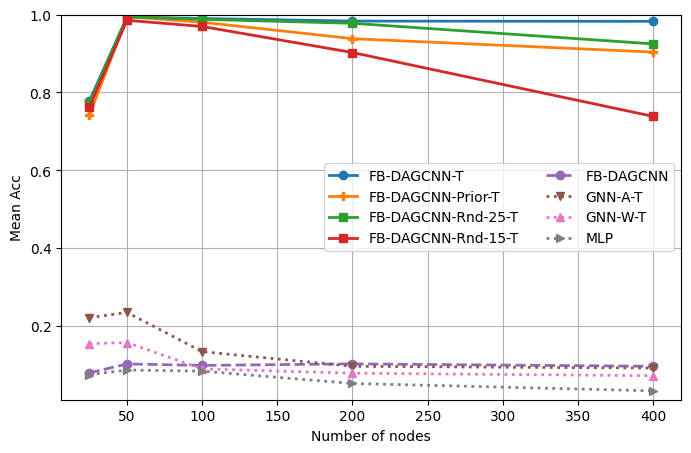

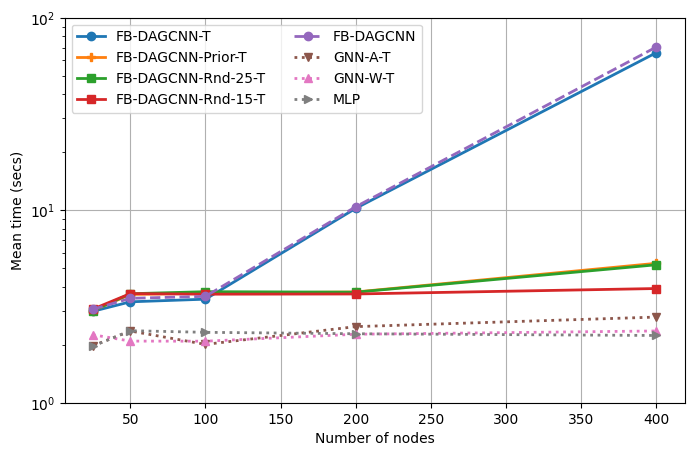

In [21]:
if SAVE:
    file_name = PATH + f'n_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=N_nodes)
    print('SAVED FILE:', file_name)

mean_acc = acc.mean(axis=0)
mean_time = times.mean(axis=0)
med_acc = np.median(acc, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_acc, N_nodes, Exps, 'Number of nodes', logy=False, n_cols=2,
                   ylabel='Mean Acc')
utils.plot_results(mean_time, N_nodes, Exps, 'Number of nodes', logy=True, ylabel='Mean time (secs)',
                   ylim_bottom=1, ylim_top=100, n_cols=2)


In [16]:
# file_name = PATH + 'n_nodes_inf-random.npz'
# acc, times, Exps, N_nodes = utils.load_data(file_name, src_id=True)

## Noise influence

In [16]:
def influence_noise(d_dat_p, d_arc_p, d_mod_p, Noise_values, exps):
    acc = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    
    t_begin = time.time()
    for i in range(d_dat_p['n_tries']):
        print('Iteration:', i)

        for j, noise in enumerate(Noise_values):
            data_params_aux = dict(d_dat_p)
            data_params_aux['n_p'] = noise
            
            Adj, W, GSOs = utils.get_graph_data(data_params_aux)

            acc[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                            Adj, exp_desc=str(Adj.shape[0]))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return acc, times

In [26]:
Noise_values = np.arange(0, .41, .05)

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True},'leg': 'FB-DAGCNN-T', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs', 'transp': True}, 'leg': 'FB-DAGCNN-Prior-T',
     'fmt': 'P-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 25, 'transp': True}, 'leg': 'FB-DAGCNN-Rnd-25-T',
     'fmt': 's-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 15, 'transp': True}, 'leg': 'FB-DAGCNN-Rnd-15-T',
     'fmt': 's-'}, 
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': False},'leg': 'FB-DAGCNN', 'fmt': 'o--'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A', 'transp': True}, 'leg': 'GNN-A-T', 'fmt': 'v:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'W', 'transp': True}, 'leg': 'GNN-W-T', 'fmt': '^:'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP', 'fmt': '>:'},
    ]

acc, times = influence_noise(data_p, default_arch_p, default_mod_p, Noise_values, Exps)


SAVED FILE: results/src_id/noise_inf-random


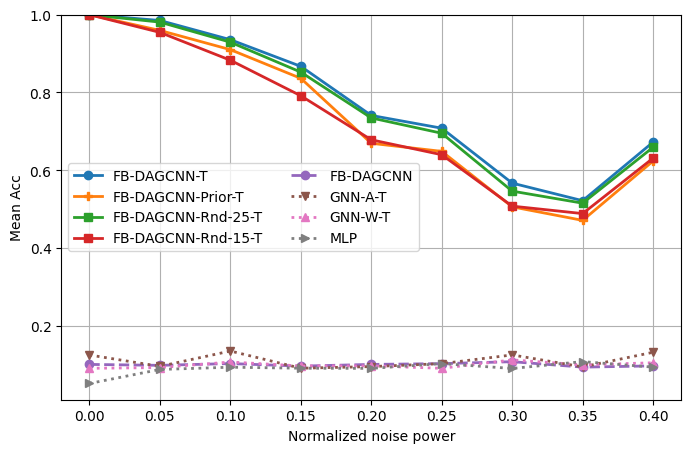

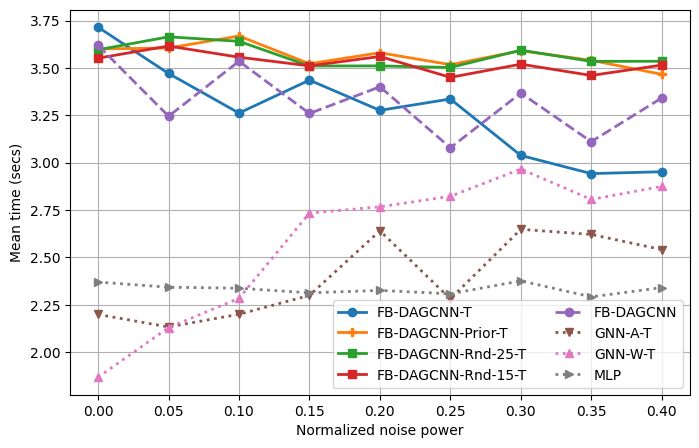

In [31]:
if SAVE:
    file_name = PATH + f'noise_inf-{data_p["src_t"]}'
    np.savez(file_name, acc=acc, times=times, exp=Exps, xvals=Noise_values)
    print('SAVED FILE:', file_name)

mean_acc = acc.mean(axis=0)
mean_time = times.mean(axis=0)
med_acc = np.median(acc, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_acc, Noise_values, Exps, 'Normalized noise power', ylabel='Mean Acc',
                   logy=False, n_cols=2)
utils.plot_results(mean_time, Noise_values, Exps, 'Normalized noise power', logy=False, ylabel='Mean time (secs)',
                   ylim_bottom=None, ylim_top=None, n_cols=2)


In [24]:
# file_name = PATH + 'noise_inf-random.npz'
# acc, times, Exps, Noise_values = utils.load_data(file_name, src_id=True)